# Autoencoders

En este _notebook_ vamos a aprender sobre _autoencoders_. Un _autoencoders_ es un tipo de red neuronal que aprende a encontrar un _encoding_ eficiente para un _dataset_; por lo tanto, es un tipo de aprendizaje no supervisado, y puede utilizarse para reducir dimensionalidad de un _dataset_. 

En este ejemplo vamos a trabajar con el _dataset_ MNIST.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

X, y = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Al igual que cuando utilizábamos PCA, es recomendable estandarizar nuestros datos.

In [2]:
from sklearn.preprocessing import StandardScaler

std_sclr = StandardScaler()
X_train_std = std_sclr.fit_transform(X_train)
X_test_std = std_sclr.transform(X_test)

## Reduciendo dimensiones con un autoencoder

La idea general del _autoencoder_ es aprovecharnos de que una red neuronal puede aprender su propia representación de los datos. Supongamos que tenemos una red con una única _hidden layer_; a grandes rasgos, esta _layer_ lo que hace es aprender la representación más apropiada para resolver el problema. Así, un _autoencoder_ en vez de entregarnos un _output_ (por ejemplo, una respuesta de un problema de clasificación), nos entrega una representación en menos dimensiones.

El _autoencoder_ se divide en dos componentes, una red neuronal **_encoder_** y otra red **_decoder_**. La red _encoder_ aprende a tomar una instancia y representarla en una nueva dimensionalidad, mientras que la red _decoder_ toma una instancia en la nueva dimensionalidad y la deja en la dimensión original.

¿Pero cómo entrenamos esta red? La idea es primero instanciar la red _enconder_, luego la red _decoder_, y hacer que el _output_ de la red _encoder_ sea el _input_ de la _decoder_. Esto forma una gran red que será nuestro _autoencoder_. La parte interesante es que el input del _autoencoder_ son las instancias que queremos reducir, y para cada instancia, su respuesta es la misma instancia, ya que lo que queremos es que la respuesta del _autoencoder_ (es decir, la respuesta de la red _decoder_) sea la misma instancia que habíamos entregado al _autoencoder_ (es decir, el _input_ del _encoder_).

In [3]:
from tensorflow import keras

num_dim = len(X_train.columns)

# Red encoder, recibe un input de dimensión num_dim
# Entrega un output de dimensión 5
encoder = keras.models.Sequential([
    keras.layers.Dense(5),
])

# Red decoder, recibe un input de dimensión 5
# Entrega un output de dimensión num_dim
decoder = keras.models.Sequential([
    keras.layers.Dense(num_dim),
])

# Concatenamos el encoder con el decoder
autoencoder = keras.models.Sequential([encoder, decoder])

# Compilamos el modelo
autoencoder.compile(
    loss='mse', 
    optimizer=keras.optimizers.SGD(learning_rate=0.1)
)

# El entrenamiento toma los datos originales, los codifica/decodifica 
# en vectores de la misma dimensión.
# Decidimos que debe parar si la métrica del MSE no mejora en 10 épocas. 
autoencoder.fit(
    X_train_std, X_train_std, 
    epochs=100, validation_data=(X_test_std, X_test_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# Ahora vamos a reducir la dimensión del dataset de prueba
# Simplemente llamamos al encoder
X_auto = encoder.predict(X_test_std)

Epoch 1/100
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8342 - val_loss: 0.7635
Epoch 2/100
1875/1875 [==============================] - 2s 944us/step - loss: 0.7499 - val_loss: 0.7478
Epoch 3/100
1875/1875 [==============================] - 2s 939us/step - loss: 0.7451 - val_loss: 0.7456
Epoch 4/100
1875/1875 [==============================] - 2s 931us/step - loss: 0.7438 - val_loss: 0.7448
Epoch 5/100
1875/1875 [==============================] - 2s 915us/step - loss: 0.7432 - val_loss: 0.7445
Epoch 6/100
1875/1875 [==============================] - 2s 918us/step - loss: 0.7430 - val_loss: 0.7441
Epoch 7/100
1875/1875 [==============================] - 2s 943us/step - loss: 0.7429 - val_loss: 0.7441
Epoch 8/100
1875/1875 [==============================] - 2s 916us/step - loss: 0.7427 - val_loss: 0.7440
Epoch 9/100
1875/1875 [==============================] - 2s 926us/step - loss: 0.7427 - val_loss: 0.7438
Epoch 10/100
1875/1875 [==============================] -

Ahora veamos cómo resultó la reducción de dimensionalidad.

In [4]:
X_auto

array([[-5.7988992e+00,  1.7810218e+00, -1.4026288e+00, -3.4711971e+00,
         3.4450185e+00],
       [ 1.7704525e+00, -4.4218102e+00,  3.0685527e+00,  9.8014402e+00,
        -8.5204859e+00],
       [-4.7570415e+00,  2.6641319e+00,  4.5884690e+00, -6.9501901e-01,
        -4.1335206e+00],
       ...,
       [-2.1572463e-01,  4.8436666e+00, -3.1371403e+00, -2.0285618e+00,
         1.5560164e+00],
       [-1.8014403e-03,  2.0610003e+00,  3.3297570e+00, -5.3294001e+00,
        -1.7652885e+00],
       [ 9.4273319e+00, -5.5489469e+00, -5.5007229e+00, -8.8151836e-01,
        -8.3772469e+00]], dtype=float32)

## Probando el enfoque en un entorno de clasificación

¿Cómo podemos saber si esta reducción de dimensionalidad sirve de algo? Una posibilidad es probarlo de forma indirecta: ejecutando algún tipo de tarea de aprendizaje sobre estos datos, y comparando los resultados.

Aquí, comparamos con la tarea de clasificar los números de MNIST usando un árbol de decisión. Vamos a comparar el resultado de usar el árbol de decisión sobre el _dataset_ original, usando PCA, y usando un _autoencoder_.

Partimos analizando el _dataset_ original.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()

scores = cross_val_score(clf, X_test_std, y_test, cv=5, scoring='accuracy')
np.mean(scores)

0.7936

Ahora para el dataset transformado con un _autoencoder_.

In [6]:
scores = cross_val_score(clf, X_auto, y_test, cv=5, scoring='accuracy')
np.mean(scores)

0.635

Y finalmente probamos con la reducción de dimensionalidad de PCA

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X_train_std)
X_test_pca = pca.transform(X_test)

In [8]:
scores = cross_val_score(clf, X_test_pca, y_test, cv=5, scoring='accuracy')
np.mean(scores)

0.6303

## Creando mejores autoencoders

¿Es posible mejorar el desempeño del _autoencoder_? Una primera idea es agregar más capas a las redes _encoder_ y _decoder_. Por lo mismo, lo que vamos hacer es pasar de la dimensión original a 200 neuronas, luego a 50 y luego a 5. Después para decodificar, vamos a ir de 5 a 50, de 50 a 200 y de 200 a la dimensión original.

In [9]:
# El input es de la dimensión original del dataset
encoder = keras.models.Sequential([
    keras.layers.Dense(200),
    keras.layers.Dense(50),
    keras.layers.Dense(5),
])

# El output es de la dimensión original del dataset
decoder = keras.models.Sequential([
    keras.layers.Dense(50),
    keras.layers.Dense(200),
    keras.layers.Dense(num_dim),
])

autoencoder = keras.models.Sequential([encoder, decoder])

# Compilamos el modelo
autoencoder.compile(
    loss='mse', 
    optimizer=keras.optimizers.SGD(learning_rate=0.1)
)

# El entrenamiento toma los datos originales, los codifica/decodifica 
# en vectores de la misma dimensión.
# Decidimos que debe parar si la métrica del MSE no mejora en 10 épocas. 
autoencoder.fit(
    X_train_std, X_train_std, 
    epochs=100, validation_data=(X_test_std, X_test_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# Ahora vamos a reducir la dimensión del dataset de prueba
# Simplemente llamamos al encoder
X_auto_deep = encoder.predict(X_test_std)

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.7963 - val_loss: 0.7491
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7570 - val_loss: 0.7686
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7480 - val_loss: 0.7450
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7436 - val_loss: 0.7444
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7430 - val_loss: 0.7441
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7429 - val_loss: 0.7444
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7428 - val_loss: 0.7442
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7427 - val_loss: 0.7438
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7427 - val_loss: 0.7439
Epoch 10/100
1875/1875 [==============================] - 5s 2ms/step - l

Veamos ahora la _performance_ en el problema de clasificación.

In [10]:
scores = cross_val_score(clf, X_auto_deep, y_test, cv=5, scoring='accuracy')
np.mean(scores)

0.6324

Como vemos, no nos estamos acercando al valor del _accuracy_ sin reducción de dimensionalidad. Ahora para entender mejor el resultado, vamos a comprimir y descomprimir una imagen, visualizando su descompresión.

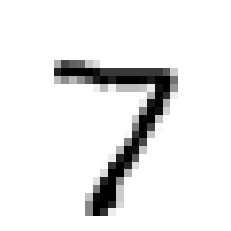

In [11]:
some_digit = X_test.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [12]:
some_digit_std = std_sclr.transform([some_digit])
some_digit_compressed = encoder.predict(some_digit_std)
some_digit_compressed

array([[ 0.56924  ,  3.665839 ,  2.5347252,  1.7768265, -0.9328206]],
      dtype=float32)

In [13]:
some_digit_compressed.shape

(1, 5)

In [14]:
some_digit_inv = decoder.predict(some_digit_compressed)
some_digit_inv_no_std = std_sclr.inverse_transform(some_digit_inv)
some_digit_inv_no_std.shape

(1, 784)

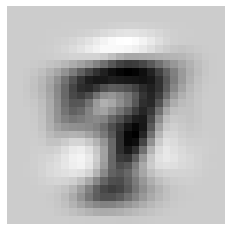

In [15]:
some_digit_image_v2 = some_digit_inv_no_std[0].reshape(28, 28)

plt.imshow(some_digit_image_v2, cmap='binary')
plt.axis('off')
plt.show()

Como vemos, el resultado es bastante malo. De todas formas, tenemos que considerar que estamos pasando de 784 a 5 dimensiones. De todas formas, veremos que podemos mejorar esto.

## Visualización de PCA

Para tener un punto de referencia, vamos a hacer una compresión con PCA a 5 dimensiones de la misma imagen.

In [16]:
some_digit_std = std_sclr.transform([some_digit])
some_digit_compressed = pca.transform(some_digit_std)
some_digit_compressed

array([[-5.03126719,  3.64113018, -7.32273826, -0.55061364,  2.77316063]])

In [17]:
some_digit_compressed.shape

(1, 5)

In [18]:
some_digit_inv = pca.inverse_transform(some_digit_compressed)
some_digit_inv_no_std = std_sclr.inverse_transform(some_digit_inv)
some_digit_inv_no_std.shape

(1, 784)

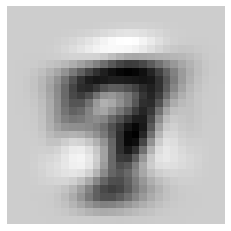

In [19]:
some_digit_image_v2_pca = some_digit_inv_no_std[0].reshape(28, 28)

plt.imshow(some_digit_image_v2_pca, cmap='binary')
plt.axis('off')
plt.show()

Como vemos, las imágenes son bastante similares.

## Autoencoders con activación no lineal

Un segundo enfoque, y lo más clásico en la práctica, es agregar una activación no lineal al final de cada capa. En este caso usamos la función Scaled Exponential Linear Unit (SELU).

In [20]:
encoder = keras.models.Sequential([
    keras.layers.Dense(200, activation='selu'),
    keras.layers.Dense(50, activation='selu'),
    keras.layers.Dense(5, activation='selu'),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(50,activation='selu'),
    keras.layers.Dense(200, activation='selu'),
    keras.layers.Dense(num_dim, activation='selu'),
])

autoencoder = keras.models.Sequential([encoder, decoder])

# Compilamos el modelo
autoencoder.compile(
    loss='mse', 
    optimizer=keras.optimizers.SGD(learning_rate=0.1)
)

# El entrenamiento toma los datos originales, los codifica/decodifica 
# en vectores de la misma dimensión.
# Decidimos que debe parar si la métrica del MSE no mejora en 10 épocas. 
autoencoder.fit(
    X_train_std, X_train_std, 
    epochs=100, validation_data=(X_test_std, X_test_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

# Ahora vamos a reducir la dimensión del dataset de prueba
# Simplemente llamamos al encoder
X_auto_deep_relu = encoder.predict(X_test_std)

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.8080 - val_loss: 0.7637
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7576 - val_loss: 0.7534
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7432 - val_loss: 0.7336
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7169 - val_loss: 0.7074
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6930 - val_loss: 0.6883
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6755 - val_loss: 0.6725
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6606 - val_loss: 0.6581
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6463 - val_loss: 0.6444
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6329 - val_loss: 0.6317
Epoch 10/100
1875/1875 [==============================] - 4s 2ms/step - l

Ahora, vamos a probar el desempeño en el problema de clasificación para este _dataset_.

In [21]:
scores = cross_val_score(clf, X_auto_deep_relu, y_test, cv=5, scoring='accuracy')
np.mean(scores)

0.6845

Como vemos, hemos mejorado bastante con respecto a nuestro _baseline_. Finalmente, vamos a repetir el ejercicio de visualización, pero ahora con esto _autoencoder_.

In [22]:
some_digit_std = std_sclr.transform([some_digit])
some_digit_compressed = encoder.predict(some_digit_std)
some_digit_compressed

array([[-1.7580785 , -1.2411677 ,  2.5868561 , -0.44534963, -0.796676  ]],
      dtype=float32)

In [23]:
some_digit_compressed.shape

(1, 5)

In [24]:
some_digit_inv = decoder.predict(some_digit_compressed)
some_digit_inv_no_std = std_sclr.inverse_transform(some_digit_inv)
some_digit_inv_no_std.shape

(1, 784)

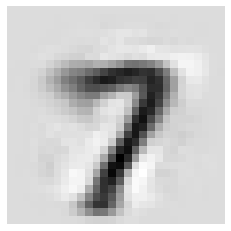

In [25]:
some_digit_image_v2 = some_digit_inv_no_std[0].reshape(28, 28)

plt.imshow(some_digit_image_v2, cmap='binary')
plt.axis('off')
plt.show()

Como vemos, es una mejora notable respecto a las otras compresiones.